In [1]:
import pandas as pd 
import math, random
all_data  = pd.read_csv("../data/sensor_data_600.txt", delimiter=" ", header=None, names = ("date","time","ir","z"))#lidarのセンサ値は「z」に
data = all_data.sample(3000).sort_values(by="z").reset_index()  #1000個だけサンプリングしてインデックスを振り直す
data = pd.DataFrame(data["z"])

In [2]:
##負担率の初期化## 

K = 3 #クラスタ数
n = int(math.ceil(len(data)/K)) #クラスタあたりのセンサ値の数
for k in range(K):
    data[k] = [1.0 if k == int(i/n) else 0.0 for i,d in data.iterrows()] #データをK個に分けて、一つのr_{i,k}を1に。他を0に。

In [3]:
def update_parameters(ds, k, mu_avg=600, zeta=1, alpha=1, beta=1, tau=1): 
    R = sum([d[k] for _, d in ds.iterrows()])
    S = sum([d[k]*d["z"] for _, d in ds.iterrows()])
    T = sum([d[k]*(d["z"]**2) for _, d in ds.iterrows()])
    
    hat = {}

    hat["tau"] = R + tau
    hat["zeta"] = R + zeta
    hat["mu_avg"] = (S + zeta*mu_avg)/hat["zeta"]
    hat["alpha"] = R/2 + alpha
    hat["beta"] = (T + zeta*(mu_avg**2) - hat["zeta"]*(hat["mu_avg"]**2))/2 + beta
    
    hat["z_std"] = math.sqrt(hat["beta"]/hat["alpha"])
    
    return pd.DataFrame(hat, index=[k])

In [4]:
from scipy.stats import norm, dirichlet
import matplotlib.pyplot as plt
import numpy as np

def draw(ps):
    pi = dirichlet([ps["tau"][k] for k in range(K)]).rvs()[0]
    pdfs = [ norm(loc=ps["mu_avg"][k], scale=ps["z_std"][k]) for k in range(K) ]

    xs = np.arange(600,650,0.5)

    ##p(z)の描画##
    ys = [ sum([pdfs[k].pdf(x)*pi[k] for k in range(K)])*len(data) for x in xs] #pdfを足してデータ数をかける
    plt.plot(xs, ys, color="red")

    ##各ガウス分布の描画##
    for k in range(K):
        ys = [pdfs[k].pdf(x)*pi[k]*len(data) for x in xs]
        plt.plot(xs, ys, color="blue")

    ##元のデータのヒストグラムの描画##
    data["z"].hist(bins = max(data["z"]) - min(data["z"]), align='left', alpha=0.4, color="gray")
    plt.show()

In [5]:
from scipy.special import digamma 

def responsibility(z, K, ps):
    tau_sum = sum([ps["tau"][k] for k in range(K)])
    r = {}
    for k in range(K):
        log_rho = (digamma(ps["alpha"][k]) - math.log(ps["beta"][k]))/2 \
                            - (1/ps["zeta"][k] + ((ps["mu_avg"][k] - z)**2)*ps["alpha"][k]/ps["beta"][k])/2 \
                            + digamma(ps["tau"][k]) - digamma(tau_sum)
                
        r[k] = math.exp(log_rho)
       
    w = sum([ r[k] for k in range(K) ]) #正規化
    for k in range(K): r[k] /= w
    
    return r

In [6]:
def one_step(ds):
    ##パラメータの更新##
    params = pd.concat([update_parameters(ds, k) for k in range(K)]) 

    ##負担率の更新##
    rs = [responsibility(d["z"], K, params) for _, d in ds.iterrows() ]
    for k in range(K):
        ds[k] = [rs[i][k] for i,_ in data.iterrows()]
        
    return ds, params

In [7]:
params_history = {} 
for t in range(1, 10000):
    data, params = one_step(data)
    if t%10 ==0:              #10回ごとにパラメータを記録
        params_history[t] = params
        display(params)
        
        if len(params_history) < 2:
            continue
           
        if all([ abs(params_history[t-10]["tau"][k] - params_history[t]["tau"][k]) < 10e-5 for k in range(K)]):
            break

,tau,zeta,mu_avg,alpha,beta,z_std
0,986.465328,986.465328,620.538906,493.732664,4897.596742,3.149529
1,944.505951,944.505951,627.868333,472.752975,7215.052735,3.906633
2,1072.028721,1072.028721,632.077755,536.514361,7682.534534,3.784091


,tau,zeta,mu_avg,alpha,beta,z_std
0,938.838678,938.838678,620.565043,469.919339,4772.983565,3.187009
1,931.360390,931.360390,628.106204,466.180195,10250.185212,4.689094
2,1132.800932,1132.800932,631.326543,566.900466,8928.520757,3.968591


,tau,zeta,mu_avg,alpha,beta,z_std
0,902.966220,902.966220,620.544445,451.983110,4493.975542,3.153220
1,897.029842,897.029842,628.072381,449.014921,11687.637420,5.101912
2,1203.003938,1203.003938,630.954427,602.001969,9643.421720,4.002364


,tau,zeta,mu_avg,alpha,beta,z_std
0,878.428558,878.428558,620.526140,439.714279,4266.371413,3.114900
1,848.269243,848.269243,627.843931,424.634622,12007.905279,5.317726
2,1276.302199,1276.302199,630.808614,638.651099,10321.066089,4.020041


,tau,zeta,mu_avg,alpha,beta,z_std
0,862.252268,862.252268,620.524787,431.626134,4113.438478,3.087085
1,793.604379,793.604379,627.534678,397.302190,11815.625001,5.453406
2,1347.143353,1347.143353,630.747890,674.071676,10981.630746,4.036272


,tau,zeta,mu_avg,alpha,beta,z_std
0,853.354103,853.354103,620.535187,427.177051,4022.002375,3.068437
1,736.859727,736.859727,627.220882,368.929863,11348.333853,5.546182
2,1412.786171,1412.786171,630.711826,706.893085,11608.791041,4.052440


,tau,zeta,mu_avg,alpha,beta,z_std
0,850.833494,850.833494,620.550490,425.916747,3980.241974,3.056978
1,679.991570,679.991570,626.940256,340.495785,10719.690416,5.610935
2,1472.174936,1472.174936,630.680327,736.587468,12194.983004,4.068913


,tau,zeta,mu_avg,alpha,beta,z_std
0,853.293147,853.293147,620.567247,427.146574,3975.909401,3.050913
1,624.209526,624.209526,626.701756,312.604763,10016.110507,5.660460
2,1525.497327,1525.497327,630.648116,763.248663,12736.221923,4.084955


,tau,zeta,mu_avg,alpha,beta,z_std
0,859.255348,859.255348,620.584169,430.127674,3997.549074,3.048584
1,570.207693,570.207693,626.499772,285.603847,9293.959706,5.704510
2,1573.536959,1573.536959,630.614831,787.268480,13233.729663,4.099961


,tau,zeta,mu_avg,alpha,beta,z_std
0,867.521249,867.521249,620.600688,434.260625,4036.262159,3.048698
1,518.315716,518.315716,626.324708,259.657858,8581.827545,5.748958
2,1617.163034,1617.163034,630.581305,809.081517,13692.051834,4.113752


,tau,zeta,mu_avg,alpha,beta,z_std
0,877.237971,877.237971,620.616441,439.118985,4085.869539,3.050360
1,468.645129,468.645129,626.167484,234.822565,7891.315269,5.797020
2,1657.116900,1657.116900,630.548364,829.058450,14116.478094,4.126393


,tau,zeta,mu_avg,alpha,beta,z_std
0,887.835710,887.835710,620.631177,444.417855,4142.320130,3.052995
1,421.192852,421.192852,626.020600,211.096426,7225.693991,5.850586
2,1693.971438,1693.971438,630.516579,847.485719,14511.715066,4.138026


,tau,zeta,mu_avg,alpha,beta,z_std
0,898.946189,898.946189,620.644722,449.973094,4203.049753,3.056251
1,375.902487,375.902487,625.877955,188.451244,6584.635533,5.911074
2,1728.151324,1728.151324,630.486288,864.575662,14881.515518,4.148796


,tau,zeta,mu_avg,alpha,beta,z_std
0,910.336634,910.336634,620.656966,455.668317,4266.493150,3.059927
1,332.698561,332.698561,625.734345,166.849280,5966.432417,5.979918
2,1759.964805,1759.964805,630.457670,880.482402,15228.709911,4.158830


,tau,zeta,mu_avg,alpha,beta,z_std
0,921.862904,921.862904,620.667838,461.431452,4331.752745,3.063926
1,291.505854,291.505854,625.584898,146.252927,5368.963988,6.058889
2,1789.631242,1789.631242,630.430816,895.315621,15555.347721,4.168231


,tau,zeta,mu_avg,alpha,beta,z_std
0,933.437756,933.437756,620.677284,467.218878,4398.387280,3.068220
1,252.261157,252.261157,625.424451,126.630578,4790.088563,6.150387
2,1817.301087,1817.301087,630.405771,909.150544,15862.834504,4.177077


,tau,zeta,mu_avg,alpha,beta,z_std
0,945.009692,945.009692,620.685255,473.004846,4466.285151,3.072843
1,214.921786,214.921786,625.246765,107.960893,4227.783005,6.257821
2,1843.068522,1843.068522,630.382568,922.034261,16152.028959,4.185429


,tau,zeta,mu_avg,alpha,beta,z_std
0,956.548674,956.548674,620.691690,478.774337,4535.600948,3.077882
1,179.473845,179.473845,625.043332,90.236923,3680.176834,6.386195
2,1866.977480,1866.977480,630.361249,933.988740,16423.288746,4.193332


,tau,zeta,mu_avg,alpha,beta,z_std
0,968.035957,968.035957,620.696508,484.517979,4606.746272,3.083488
1,145.943006,145.943006,624.801263,73.471503,3145.548638,6.543178
2,1889.021037,1889.021037,630.341888,945.010518,16676.455786,4.200815


,tau,zeta,mu_avg,alpha,beta,z_std
0,979.455493,979.455493,620.699593,490.227747,4680.438308,3.089899
1,114.411799,114.411799,624.498947,57.705900,2622.321508,6.741132
2,1909.132708,1909.132708,630.324608,955.066354,16910.758515,4.207894


,tau,zeta,mu_avg,alpha,beta,z_std
0,990.783612,990.783612,620.700784,495.891806,4757.830226,3.097498
1,85.051220,85.051220,624.095809,43.025610,2109.088631,7.001384
2,1927.165168,1927.165168,630.309610,964.082584,17124.576665,4.214565


,tau,zeta,mu_avg,alpha,beta,z_std
0,1001.969665,1001.969665,620.699866,501.484833,4840.775961,3.106909
1,58.185509,58.185509,623.503525,29.592755,1604.719771,7.363883
2,1942.844825,1942.844825,630.297220,971.922413,17314.924285,4.220797


,tau,zeta,mu_avg,alpha,beta,z_std
0,1012.883764,1012.883764,620.696620,506.941882,4932.286761,3.119213
1,34.444597,34.444597,622.482477,17.722298,1108.598907,7.909102
2,1955.671640,1955.671640,630.287973,978.335820,17476.232193,4.226491


,tau,zeta,mu_avg,alpha,beta,z_std
0,1023.132607,1023.132607,620.691223,512.066303,5036.676970,3.136238
1,15.186390,15.186390,620.097007,8.093195,619.761816,8.750894
2,1964.681003,1964.681003,630.282745,982.840502,17596.945907,4.231332


,tau,zeta,mu_avg,alpha,beta,z_std
0,1031.516433,1031.516433,620.686924,516.258216,5152.353201,3.159143
1,3.499864,3.499864,610.496195,2.249932,126.782375,7.506626
2,1967.983704,1967.983704,630.282447,984.491852,17648.737127,4.233999


,tau,zeta,mu_avg,alpha,beta,z_std
0,1037.837982,1037.837982,620.694291,519.418991,5321.180468,3.200701
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1964.162018,1964.162018,630.289598,982.581009,17614.532491,4.234005


,tau,zeta,mu_avg,alpha,beta,z_std
0,1042.8957,1042.8957,620.712006,521.94785,5375.579993,3.209217
1,1.0000,1.0000,600.000000,1.00000,1.000000,1.000000
2,1959.1043,1959.1043,630.304940,980.05215,17504.177923,4.226163


,tau,zeta,mu_avg,alpha,beta,z_std
0,1046.015138,1046.015138,620.721957,523.507569,5405.801528,3.213428
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1955.984862,1955.984862,630.314917,978.492431,17430.130565,4.220575


,tau,zeta,mu_avg,alpha,beta,z_std
0,1047.922398,1047.922398,620.728048,524.461199,5424.353491,3.216009
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1954.077602,1954.077602,630.321014,977.538801,17384.989708,4.217161


,tau,zeta,mu_avg,alpha,beta,z_std
0,1049.088238,1049.088238,620.731776,525.044119,5435.731803,3.217593
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1952.911762,1952.911762,630.324738,976.955881,17357.464498,4.215078


,tau,zeta,mu_avg,alpha,beta,z_std
0,1049.800824,1049.800824,620.734056,525.400412,5442.700888,3.218563
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1952.199176,1952.199176,630.327014,976.599588,17340.665961,4.213807


,tau,zeta,mu_avg,alpha,beta,z_std
0,1050.236356,1050.236356,620.735451,525.618178,5446.965805,3.219157
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1951.763644,1951.763644,630.328404,976.381822,17330.408246,4.213030


,tau,zeta,mu_avg,alpha,beta,z_std
0,1050.502548,1050.502548,620.736303,525.751274,5449.574481,3.219520
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1951.497452,1951.497452,630.329253,976.248726,17324.142391,4.212555


,tau,zeta,mu_avg,alpha,beta,z_std
0,1050.665238,1050.665238,620.736824,525.832619,5451.169552,3.219742
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1951.334762,1951.334762,630.329773,976.167381,17320.314224,4.212266


,tau,zeta,mu_avg,alpha,beta,z_std
0,1050.76467,1050.76467,620.737143,525.882335,5452.144739,3.219878
1,1.00000,1.00000,600.000000,1.000000,1.000000,1.000000
2,1951.23533,1951.23533,630.330090,976.117665,17317.975017,4.212088


,tau,zeta,mu_avg,alpha,beta,z_std
0,1050.82544,1050.82544,620.737338,525.91272,5452.740834,3.219961
1,1.00000,1.00000,600.000000,1.00000,1.000000,1.000000
2,1951.17456,1951.17456,630.330284,976.08728,17316.545566,4.211980


,tau,zeta,mu_avg,alpha,beta,z_std
0,1050.86258,1050.86258,620.737457,525.93129,5453.105179,3.220012
1,1.00000,1.00000,600.000000,1.00000,1.000000,1.000000
2,1951.13742,1951.13742,630.330402,976.06871,17315.672001,4.211914


,tau,zeta,mu_avg,alpha,beta,z_std
0,1050.885279,1050.885279,620.737529,525.942639,5453.327883,3.220043
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1951.114721,1951.114721,630.330475,976.057361,17315.138129,4.211873


,tau,zeta,mu_avg,alpha,beta,z_std
0,1050.89915,1050.89915,620.737574,525.949575,5453.463972,3.220062
1,1.00000,1.00000,600.000000,1.000000,1.000000,1.000000
2,1951.10085,1951.10085,630.330519,976.050425,17314.811917,4.211849


,tau,zeta,mu_avg,alpha,beta,z_std
0,1050.90763,1050.90763,620.737601,525.953815,5453.547158,3.220073
1,1.00000,1.00000,600.000000,1.000000,1.000000,1.000000
2,1951.09237,1951.09237,630.330546,976.046185,17314.612464,4.211834


,tau,zeta,mu_avg,alpha,beta,z_std
0,1050.912811,1050.912811,620.737618,525.956406,5453.598061,3.220080
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1951.087189,1951.087189,630.330562,976.043594,17314.490559,4.211824


,tau,zeta,mu_avg,alpha,beta,z_std
0,1050.915979,1050.915979,620.737628,525.95799,5453.629142,3.220085
1,1.000000,1.000000,600.000000,1.00000,1.000000,1.000000
2,1951.084021,1951.084021,630.330573,976.04201,17314.416071,4.211819


,tau,zeta,mu_avg,alpha,beta,z_std
0,1050.917916,1050.917916,620.737634,525.958958,5453.648120,3.220087
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1951.082084,1951.082084,630.330579,976.041042,17314.370548,4.211815


,tau,zeta,mu_avg,alpha,beta,z_std
0,1050.919099,1050.919099,620.737638,525.959549,5453.659730,3.220089
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1951.080901,1951.080901,630.330583,976.040451,17314.342752,4.211813


,tau,zeta,mu_avg,alpha,beta,z_std
0,1050.919821,1050.919821,620.737640,525.95991,5453.666798,3.220090
1,1.000000,1.000000,600.000000,1.00000,1.000000,1.000000
2,1951.080179,1951.080179,630.330585,976.04009,17314.325762,4.211812


,tau,zeta,mu_avg,alpha,beta,z_std
0,1050.920262,1050.920262,620.737642,525.960131,5453.671122,3.220090
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1951.079738,1951.079738,630.330586,976.039869,17314.315385,4.211811


,tau,zeta,mu_avg,alpha,beta,z_std
0,1050.920533,1050.920533,620.737642,525.960266,5453.673777,3.220091
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1951.079467,1951.079467,630.330587,976.039734,17314.309028,4.211811


,tau,zeta,mu_avg,alpha,beta,z_std
0,1050.920697,1050.920697,620.737643,525.960349,5453.675418,3.220091
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1951.079303,1951.079303,630.330588,976.039651,17314.305109,4.211810


,tau,zeta,mu_avg,alpha,beta,z_std
0,1050.9208,1050.9208,620.737643,525.9604,5453.676385,3.220091
1,1.0000,1.0000,600.000000,1.0000,1.000000,1.000000
2,1951.0792,1951.0792,630.330588,976.0396,17314.302747,4.211810


,tau,zeta,mu_avg,alpha,beta,z_std
0,1050.920861,1050.920861,620.737643,525.960431,5453.677035,3.220091
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1951.079139,1951.079139,630.330588,976.039569,17314.301273,4.211810


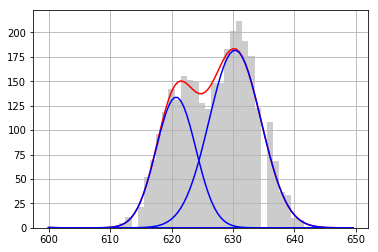

In [8]:
draw(params) 